<a href="https://colab.research.google.com/github/AnovaYoung/IoT_PhysicalTherapy/blob/main/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile
import os
import pandas as pd
import numpy as np



zip_file_path = '/Users/anovayoungers/Downloads/physical+therapy+exercises+dataset.zip'

extraction_directory = '/Users/anovayoungers/Downloads/physical_therapy_dataset'

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

    print(f'Files Extracted to {extraction_directory}')

for root, dirs, files in os.walk(extraction_directory, topdown=True):
    for name in files:
        print(os.path.join(root, name))
    for name in  dirs:
        print(os.path.join(root, name))


def load_data(file_path):
    """Load data from a specified file path into a pandas DataFrame."""
    try :
        data = pd.read_csv(file_path, sep="\t", header=None)
        return data
    except Exception as e:
        print(f"Error Loading Data: {e} ")
        return None

file_path = '/Users/anovayoungers/Downloads/physical_therapy_dataset/s1/e1/u1/test.txt'
data = load_data(file_path)

def load_data_from_directory(directory_path):
    sensor_data = []
    session_metadata = []
    times_metadata = []

    for root, dirs, files in os.walk(directory_path, topdown=True):
        parts = root.split(os.sep)
        subject = next((part for part in parts if part.startswith('s')), None)
        exercise = next((part for part in parts if part.startswith('e')), None)
        sensor_unit = next((part for part in parts if part.startswith('u')), None)

        for name in files:
            file_path = os.path.join(root, name)
            if name == 'test.txt':
                data = pd.read_csv(file_path, sep=";", header=0)
                data['subject'] = subject
                data['exercise'] = exercise
                data['sensor_unit'] = sensor_unit
                sensor_data.append(data)
            elif name == 'template_session.txt':
                session_data = pd.read_csv(file_path, sep=";", header=0)
                session_data['subject'] = subject
                session_data['exercise'] = exercise
                session_data['sensor_unit'] = sensor_unit
                session_metadata.append(session_data)
            elif name == 'template_times.txt':
                times_data = pd.read_csv(file_path, sep=";", header=0)
                times_data['subject'] = subject
                times_data['exercise'] = exercise

                times_metadata.append(times_data)

    sensor_df = pd.concat(sensor_data, ignore_index=True)
    session_df = pd.concat(session_metadata, ignore_index=True)
    times_df = pd.concat(times_metadata, ignore_index=True)

    return sensor_df, session_df, times_df

extraction_directory = '/Users/anovayoungers/Downloads/physical_therapy_dataset'
sensor_df, session_df, times_df = load_data_from_directory(extraction_directory)

In [ ]:
sensor_columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']

stats_dict = {}

for column in sensor_columns:
    mean_value = sensor_df[column].mean()
    std_dev = sensor_df[column].std()
    stats_dict[column] = {'mean': mean_value, 'std_dev': std_dev}

    print(f'{column} - Mean: {mean_value:.4f}, Standard Deviation: {std_dev:.4f}')

acc_x - Mean: 0.1088, Standard Deviation: 5.5777
acc_y - Mean: 0.8841, Standard Deviation: 6.0666
acc_z - Mean: 0.2703, Standard Deviation: 5.3354
gyr_x - Mean: 0.0037, Standard Deviation: 0.1943
gyr_y - Mean: 0.0053, Standard Deviation: 0.3048
gyr_z - Mean: -0.0064, Standard Deviation: 0.2919
mag_x - Mean: -0.1174, Standard Deviation: 0.4290
mag_y - Mean: -0.0270, Standard Deviation: 0.5084
mag_z - Mean: -0.0687, Standard Deviation: 0.4410


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
sensor_columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']
scaler = StandardScaler()
sensor_df[sensor_columns] = scaler.fit_transform(sensor_df[sensor_columns])

In [ ]:
def label_anomalies(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    df[f'{column}_anomaly'] = ((df[column] < (mean - threshold * std)) | (df[column] > (mean + threshold * std))).astype(int)
    return df

# Apply the function to each sensor column
for column in ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']:
    sensor_df = label_anomalies(sensor_df, column)


In [ ]:
adjusted_thresholds = {
    'acc_x': 2.5,
    'acc_y': 2.5,
    'acc_z': 2.5,
    'gyr_x': 3,
    'gyr_y': 3,
    'gyr_z': 3,
    'mag_x': 3,
    'mag_y': 3,
    'mag_z': 3,
}

# Re-label anomalies with adjusted thresholds
for column, threshold in adjusted_thresholds.items():
    sensor_df = label_anomalies(sensor_df, column, threshold)


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# In this case let's focus on 'acc_x' anomalies
X = sensor_df[['acc_x']]  # Features
y = sensor_df['acc_x_anomaly']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Isolation Forest (unsupervised)
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(X_train)

y_train_pred = iso_forest.predict(X_train)
y_train_pred = (y_train_pred == -1).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       1.00      0.56      0.72    880861
           1       0.00      1.00      0.00       251

    accuracy                           0.56    881112
   macro avg       0.50      0.78      0.36    881112
weighted avg       1.00      0.56      0.72    881112



In [ ]:
y_test_pred = iso_forest.predict(X_test)
y_test_pred = (y_test_pred == -1).astype(int)

from sklearn.metrics import classification_report
print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred))


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      0.56      0.72    220202
           1       0.00      1.00      0.00        76

    accuracy                           0.56    220278
   macro avg       0.50      0.78      0.36    220278
weighted avg       1.00      0.56      0.72    220278



Confusion Matrix: Training and Test data

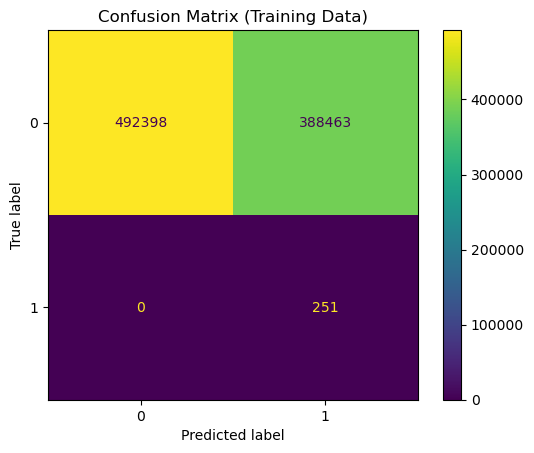

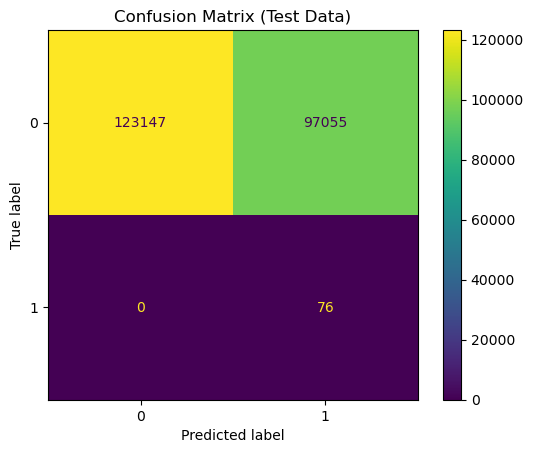

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title('Confusion Matrix (Training Data)')
plt.show()

cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title('Confusion Matrix (Test Data)')
plt.show()


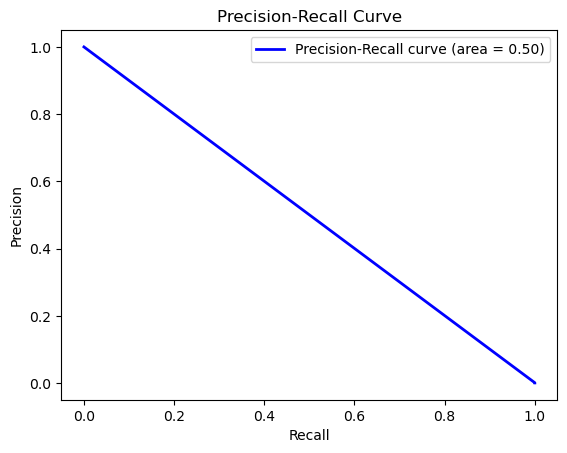

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt


precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [ ]:
zip_file_path = '/Users/anovayoungers/Downloads/physical+therapy+exercises+dataset.zip'

extraction_directory = '/Users/anovayoungers/Downloads/physical_therapy_dataset'

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

    print(f'Files Extracted to {extraction_directory}')

for root, dirs, files in os.walk(extraction_directory, topdown=True):
    for name in files:
        print(os.path.join(root, name))
    for name in  dirs:
        print(os.path.join(root, name))


def load_data(file_path):
    """Load data from a specified file path into a pandas DataFrame."""
    try :
        data = pd.read_csv(file_path, sep="\t", header=None)
        return data
    except Exception as e:
        print(f"Error Loading Data: {e} ")
        return None

file_path = '/Users/anovayoungers/Downloads/physical_therapy_dataset/s1/e1/u1/test.txt'
data = load_data(file_path)

def load_data_from_directory(directory_path):
    sensor_data = []
    session_metadata = []
    times_metadata = []

    for root, dirs, files in os.walk(directory_path, topdown=True):
        parts = root.split(os.sep)
        subject = next((part for part in parts if part.startswith('s')), None)
        exercise = next((part for part in parts if part.startswith('e')), None)
        sensor_unit = next((part for part in parts if part.startswith('u')), None)

        for name in files:
            file_path = os.path.join(root, name)
            if name == 'test.txt':
                data = pd.read_csv(file_path, sep=";", header=0)
                data['subject'] = subject
                data['exercise'] = exercise
                data['sensor_unit'] = sensor_unit
                sensor_data.append(data)
            elif name == 'template_session.txt':
                session_data = pd.read_csv(file_path, sep=";", header=0)
                session_data['subject'] = subject
                session_data['exercise'] = exercise
                session_data['sensor_unit'] = sensor_unit
                session_metadata.append(session_data)
            elif name == 'template_times.txt':
                times_data = pd.read_csv(file_path, sep=";", header=0)
                times_data['subject'] = subject
                times_data['exercise'] = exercise

                times_metadata.append(times_data)

    sensor_df = pd.concat(sensor_data, ignore_index=True)
    session_df = pd.concat(session_metadata, ignore_index=True)
    times_df = pd.concat(times_metadata, ignore_index=True)

    return sensor_df, session_df, times_df

extraction_directory = '/Users/anovayoungers/Downloads/physical_therapy_dataset'
sensor_df, session_df, times_df = load_data_from_directory(extraction_directory)

In [ ]:
sensor_columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']
scaler = StandardScaler()
sensor_df[sensor_columns] = scaler.fit_transform(sensor_df[sensor_columns])

In [ ]:
def label_anomalies(row, mean, std_dev, threshold=3):
    # Iterate over each column and check if any value is an anomaly
    for col in sensor_columns:
        if abs(row[col] - mean[col]) > threshold * std_dev[col]:
            return 1  # Mark as anomaly
    return 0  # Mark as normal if no anomaly is detected

# Calculate mean and standard deviation for the gyroscope readings
mean = sensor_df[sensor_columns].mean()
std_dev = sensor_df[sensor_columns].std()

# Apply the labeling function row-wise with a lambda to pass additional arguments
sensor_df['synthetic_anomaly'] = sensor_df.apply(lambda row: label_anomalies(row, mean, std_dev), axis=1)


In [ ]:
X = sensor_df[sensor_columns]
y = sensor_df['synthetic_anomaly']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(X_train)

y_train_pred = iso_forest.predict(X_train)
y_train_pred = (y_train_pred == -1).astype(int)

y_val_pred = iso_forest.predict(X_val)
y_val_pred = (y_val_pred == -1).astype(int)

print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    210557
           1       0.64      0.92      0.75      9721

    accuracy                           0.97    220278
   macro avg       0.82      0.95      0.87    220278
weighted avg       0.98      0.97      0.98    220278



Model evaluation

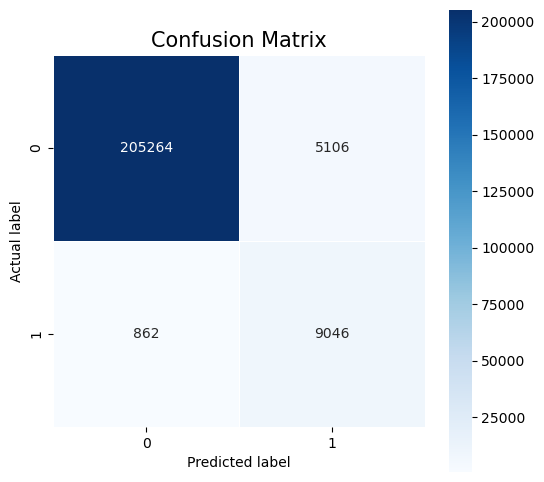

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.show()



ROC Curve

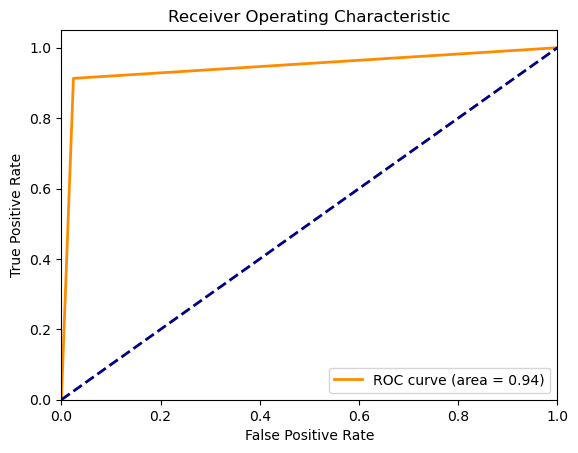

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Precision Recall Curve

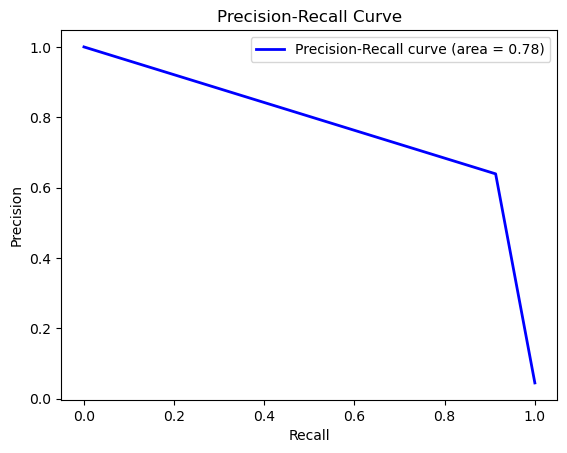

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt


precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()
